In [1]:
%load_ext autoreload
%autoreload 2
# use IPython extension to automatically reload the imported modules; 
# otherwise after editing a module, changes will not be effective without kernel restart

from globalvars import *
from preprocessings import *

In [2]:
data_buf, descriptions = initialization()
#   data_buf = {'power':[array([time,val]),...], 'force':[array([time,val]),...]}
#   descriptions.columns.values # column titles
#   descriptions.iloc[0,:] ordescriptions.loc[1,:]   # get the first row with attributes

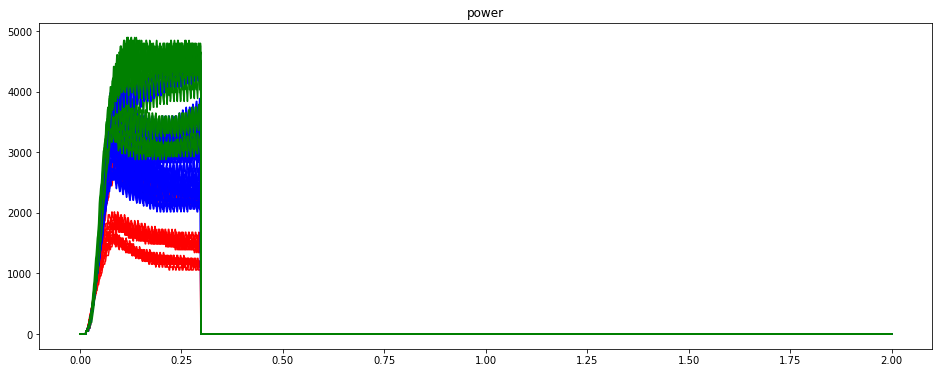

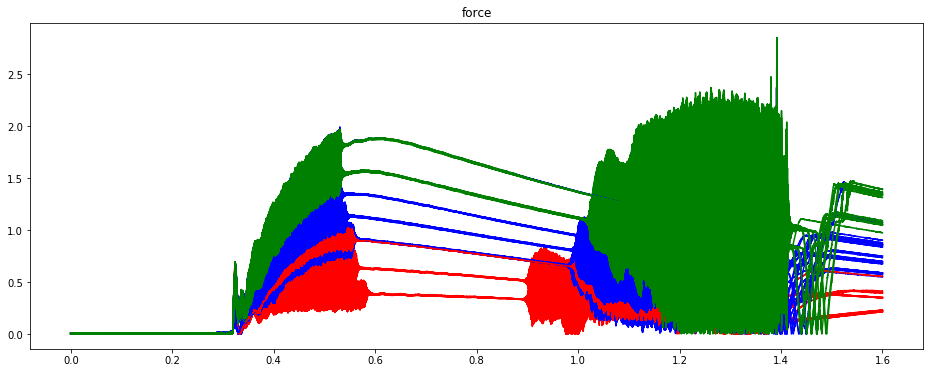

In [3]:
# data visualization

for signal in signal_type:
    fig = plt.figure(figsize = (16,6))
    class_color={'I':'r', 'II':'g', 'III':'b'}
    l = len(data_buf[signal])
    for i in range(l):
        color_tmp = class_color[descriptions.loc[i+1,'Class Label']]
        plt.title(signal)
        plt.plot(data_buf[signal][i][:,0],data_buf[signal][i][:,1],color=color_tmp)
    plt.show()

In [4]:
### 1. preprocessing

data,seg_ind = segment_all(data_buf)

C:\ProgramData\Anaconda4\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


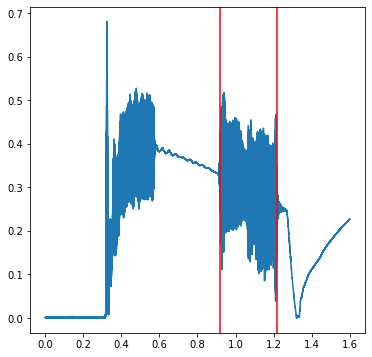

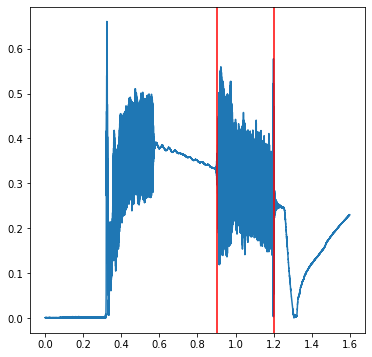

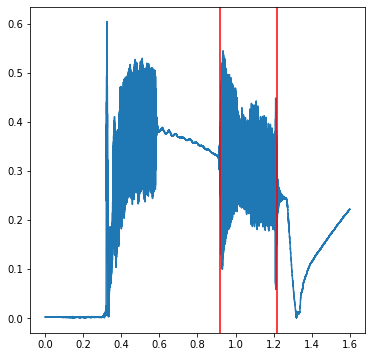

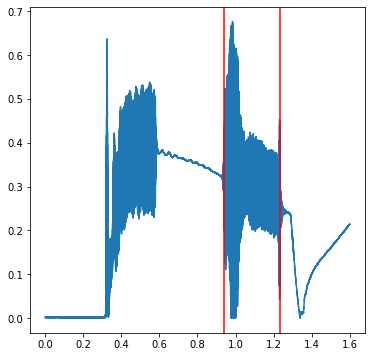

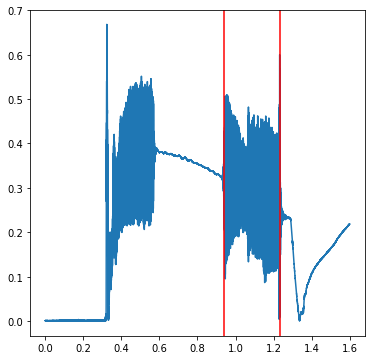

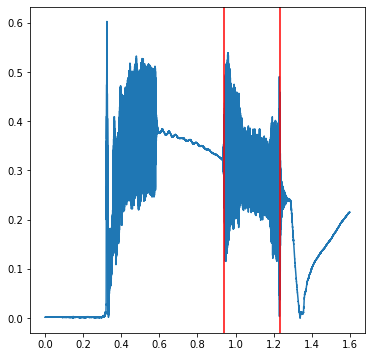

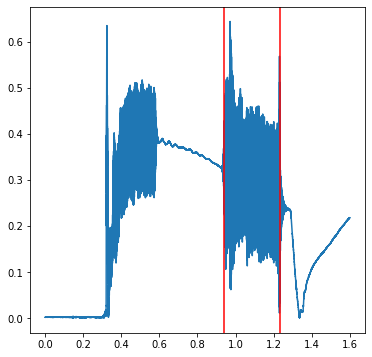

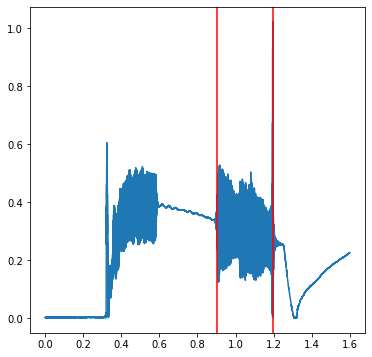

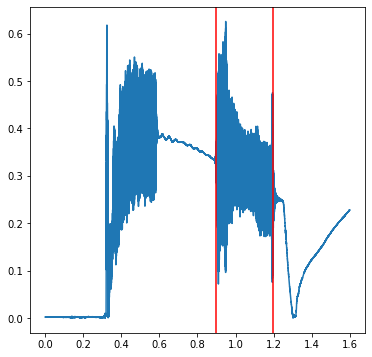

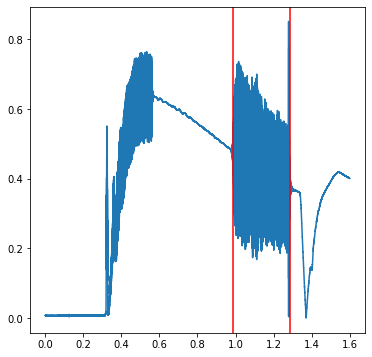

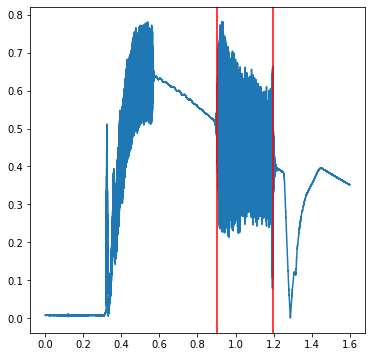

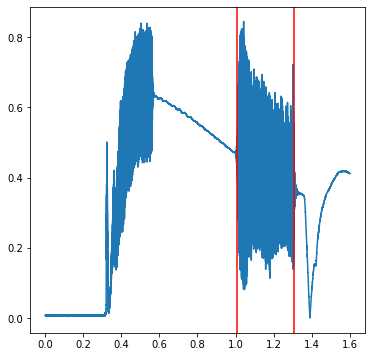

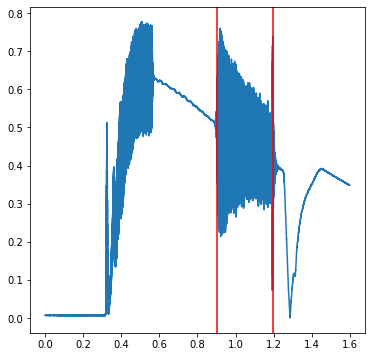

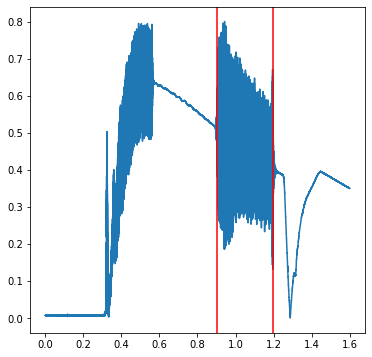

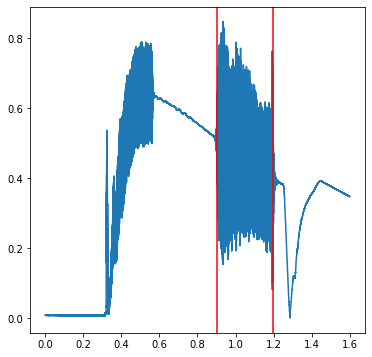

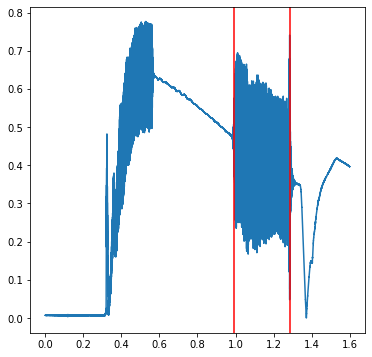

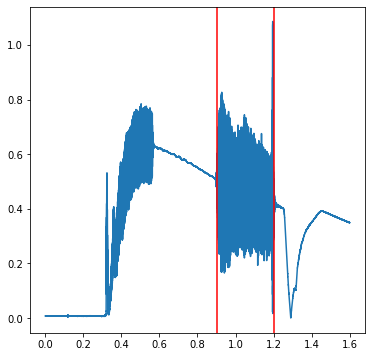

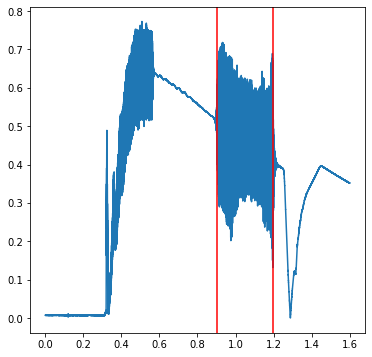

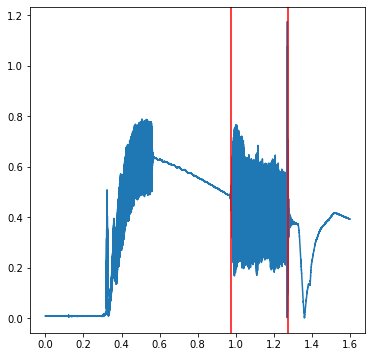

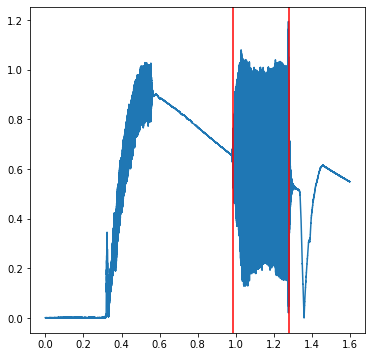

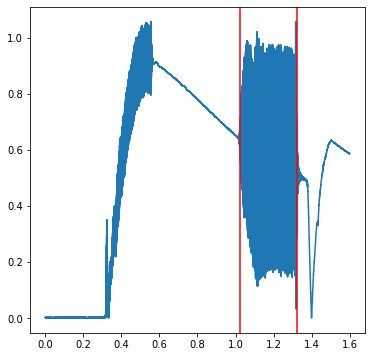

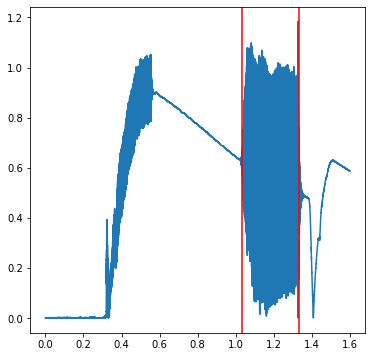

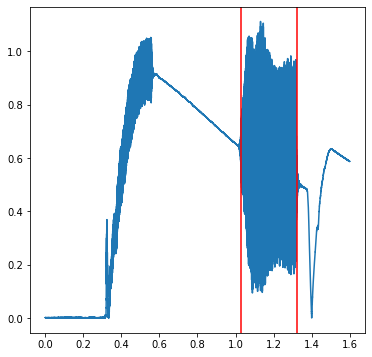

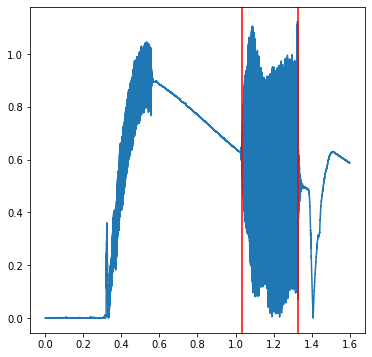

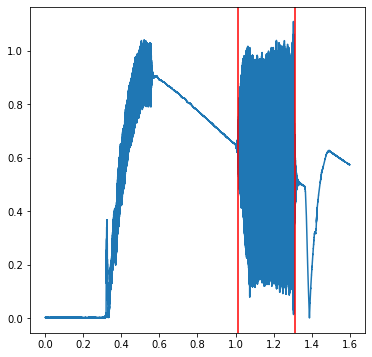

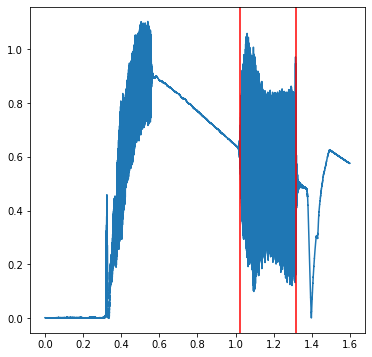

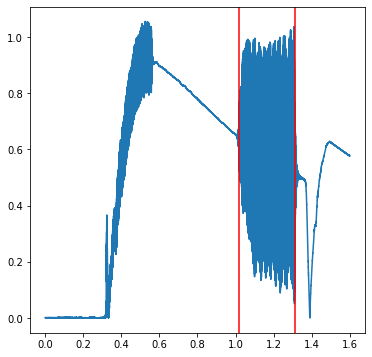

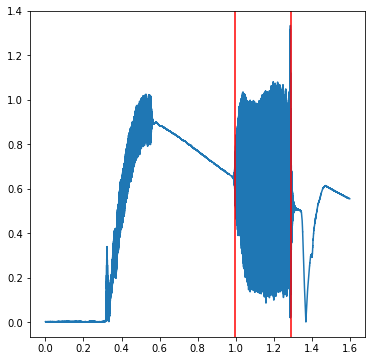

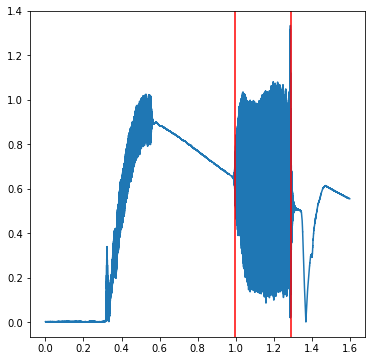

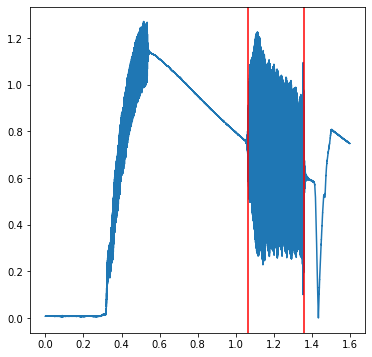

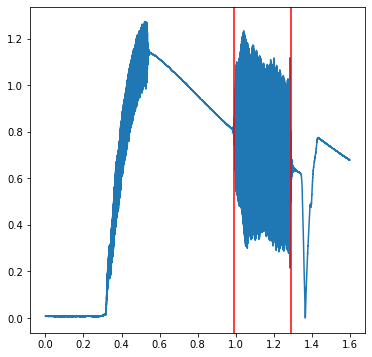

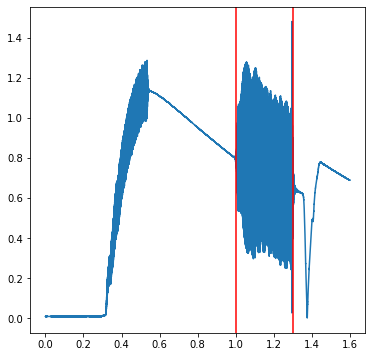

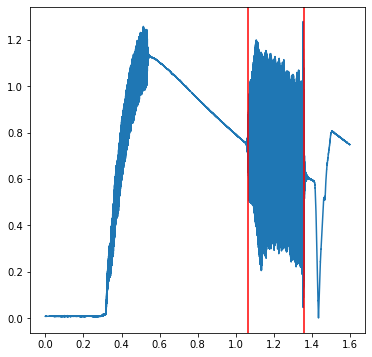

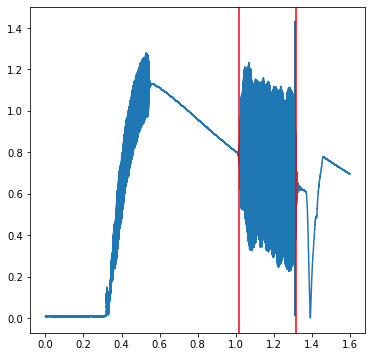

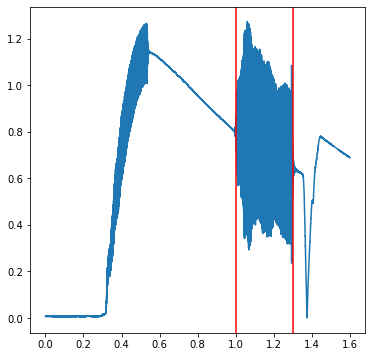

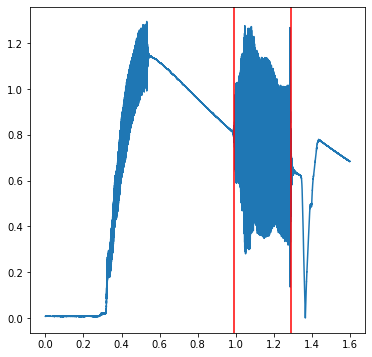

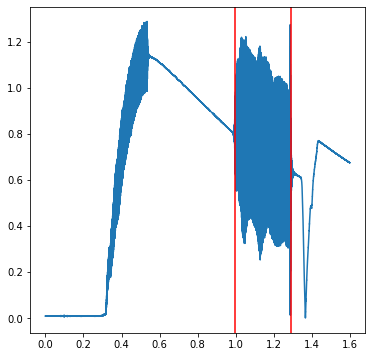

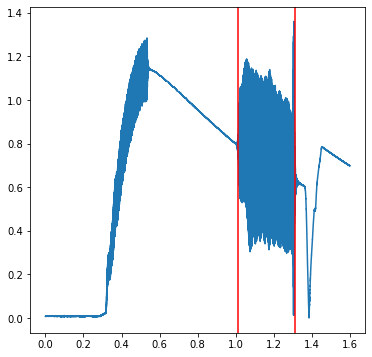

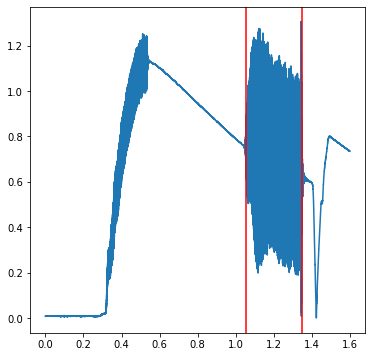

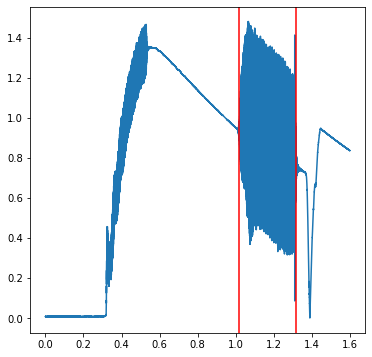

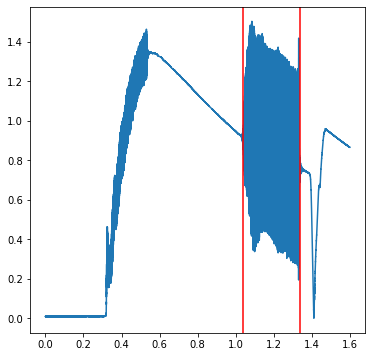

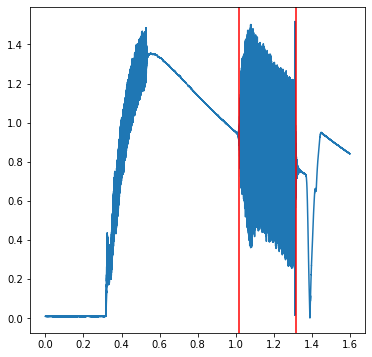

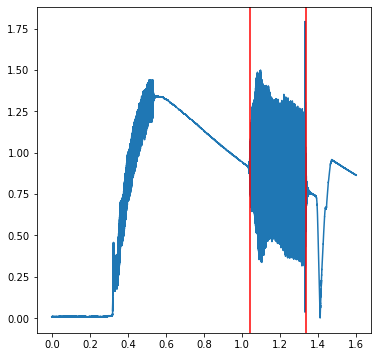

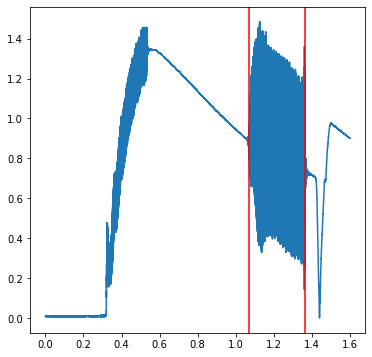

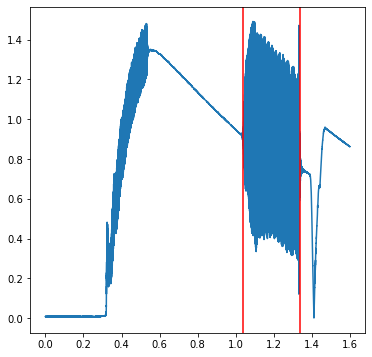

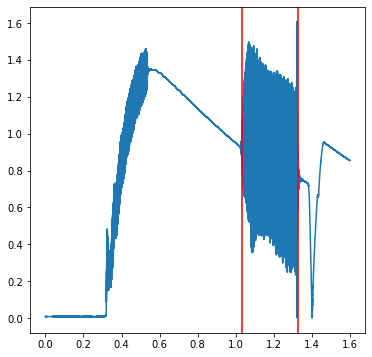

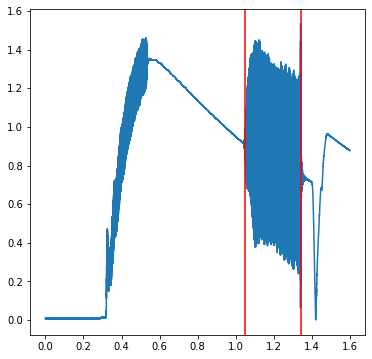

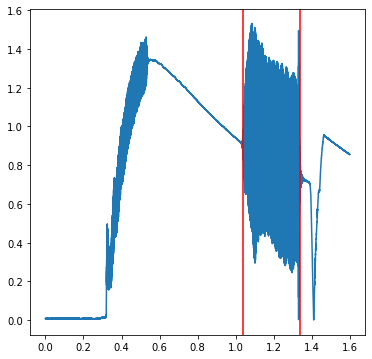

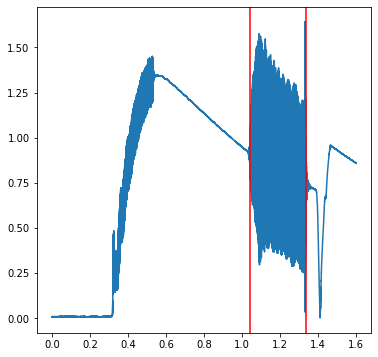

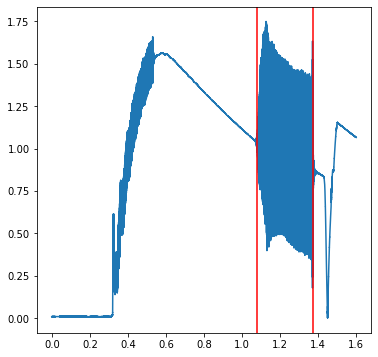

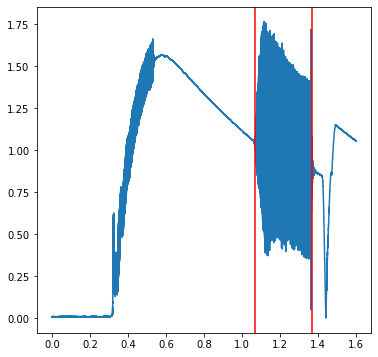

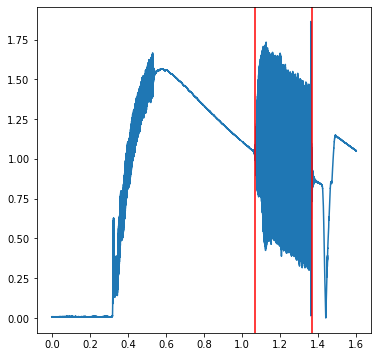

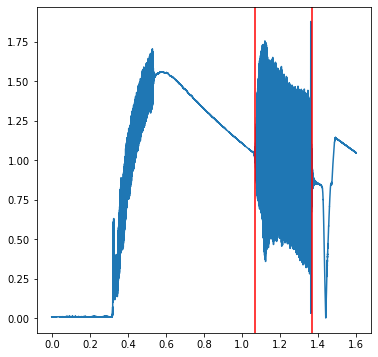

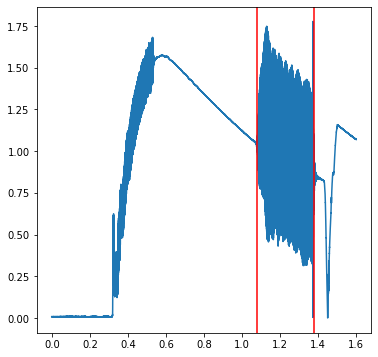

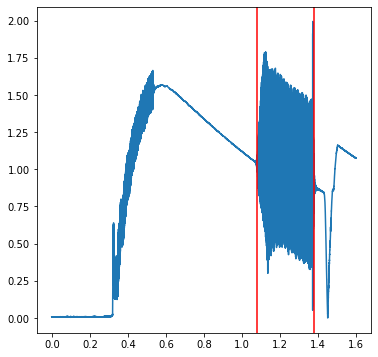

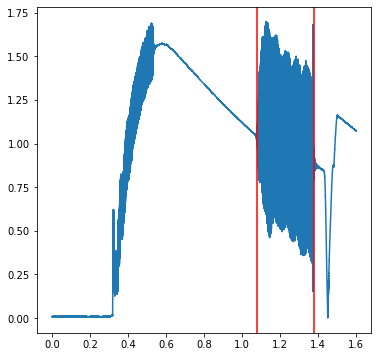

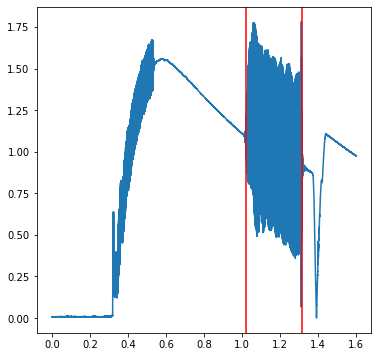

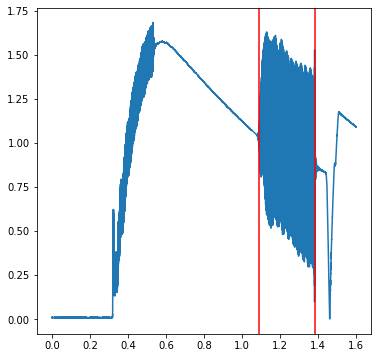

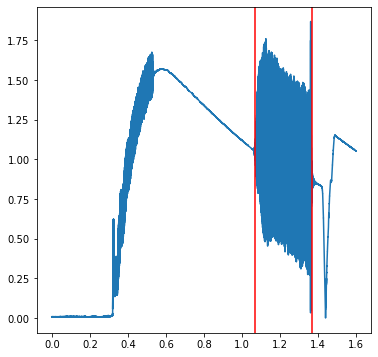

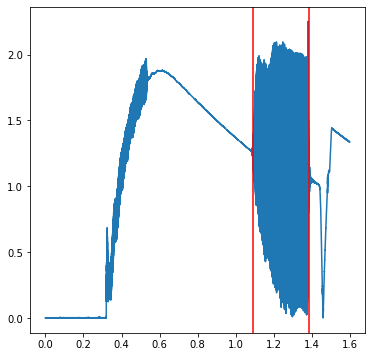

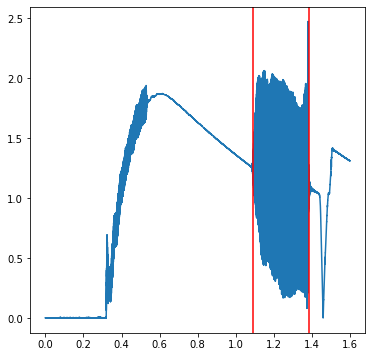

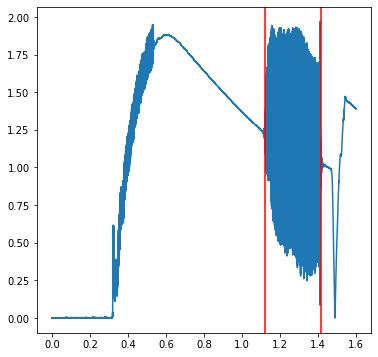

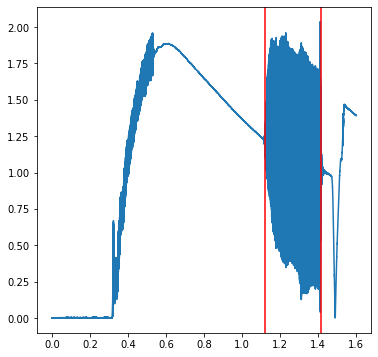

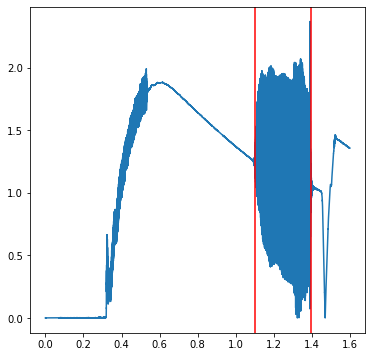

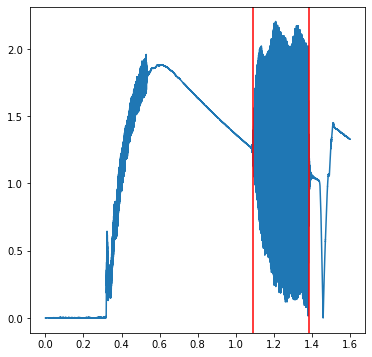

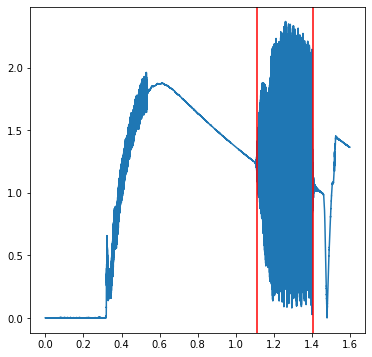

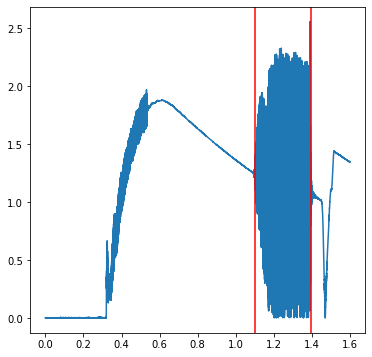

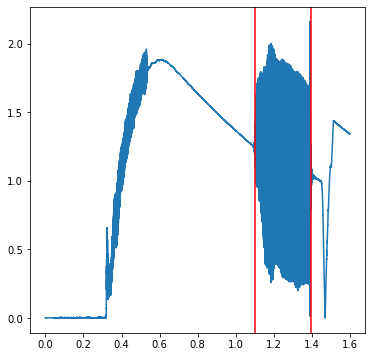

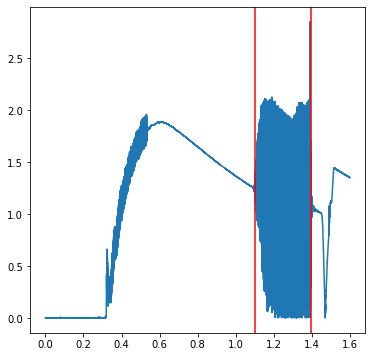

In [5]:
for i,sig in enumerate(data_buf['force']):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(sig[:,0],sig[:,1])
    for ind in seg_ind['force'][i]:
        plt.axvline(x=sig[ind,0],color='r')

C:\ProgramData\Anaconda4\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


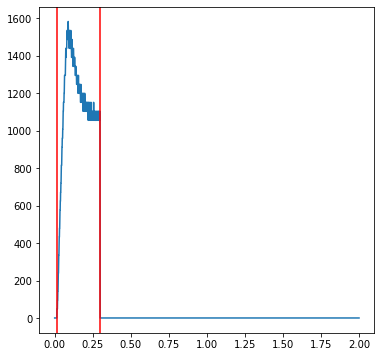

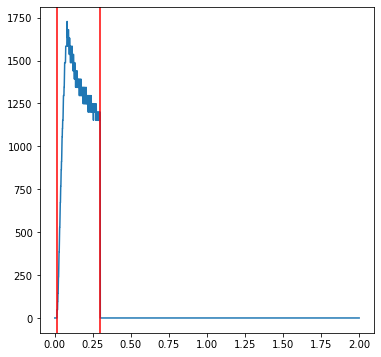

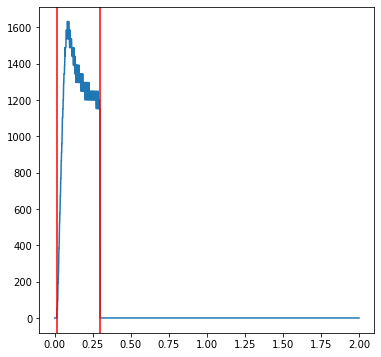

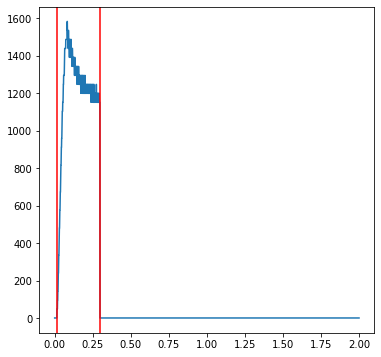

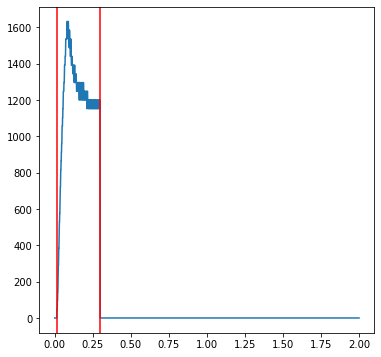

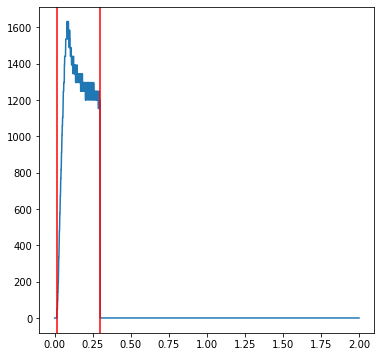

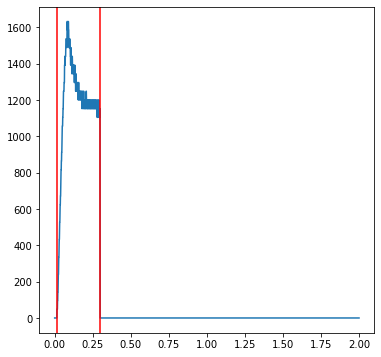

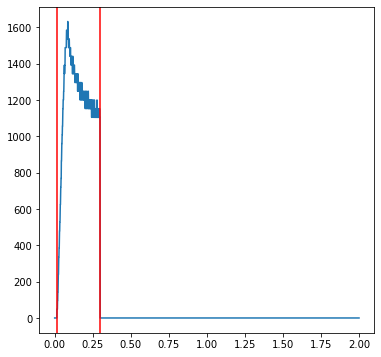

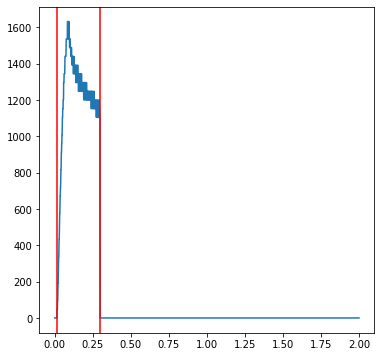

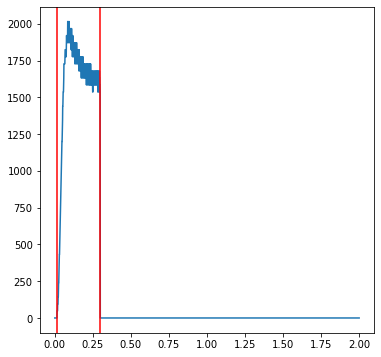

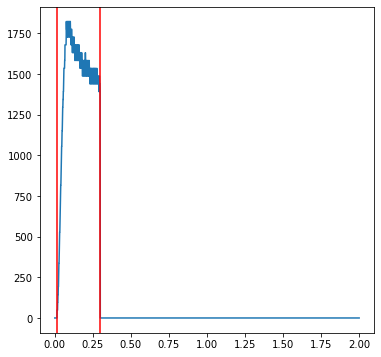

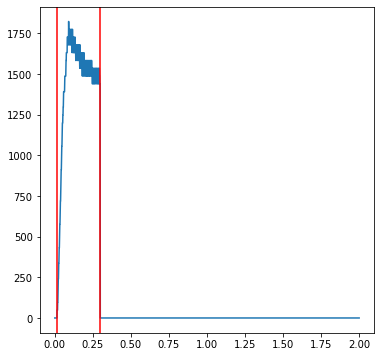

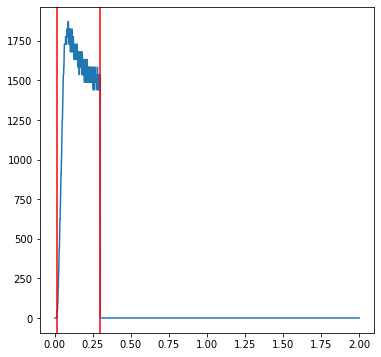

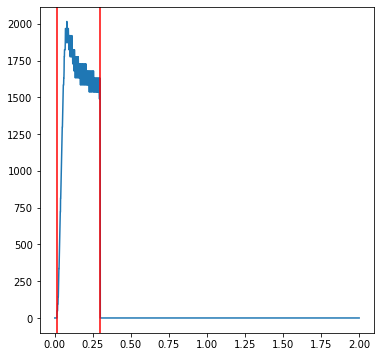

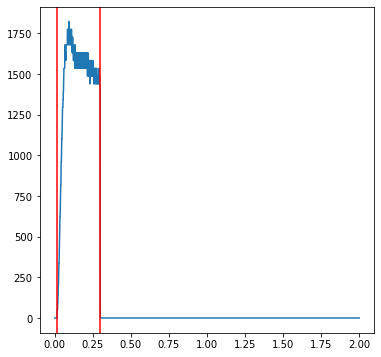

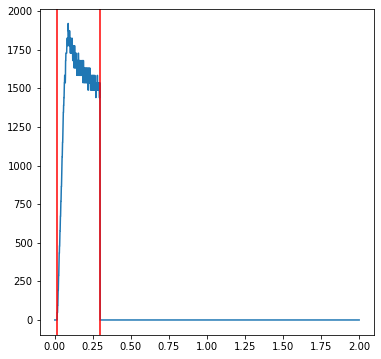

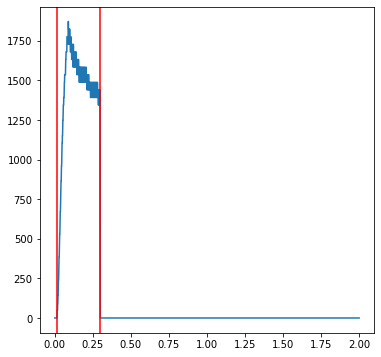

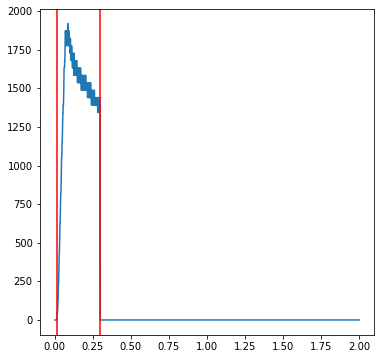

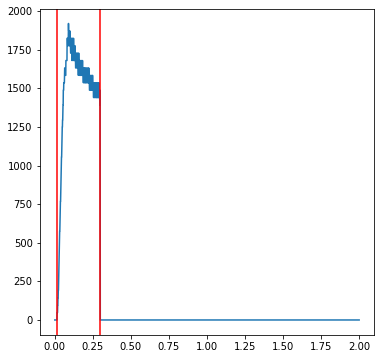

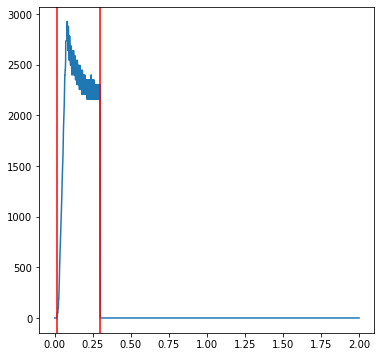

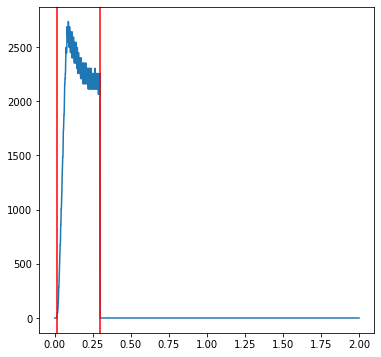

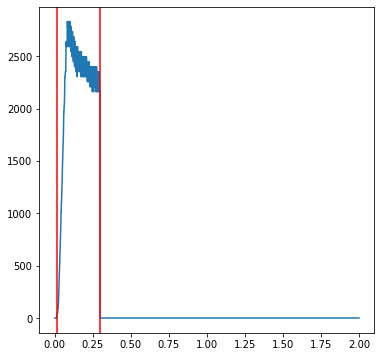

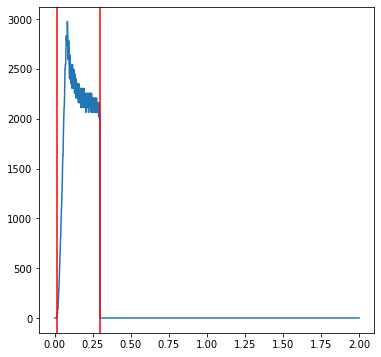

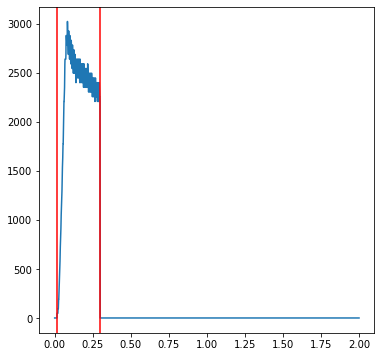

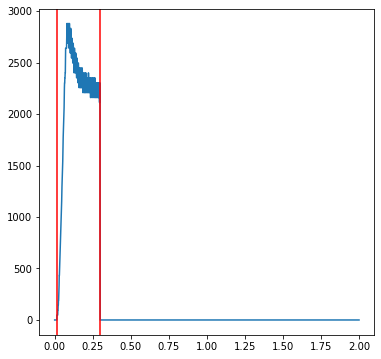

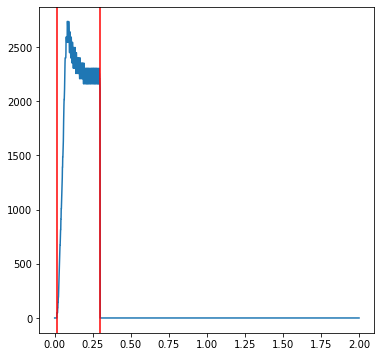

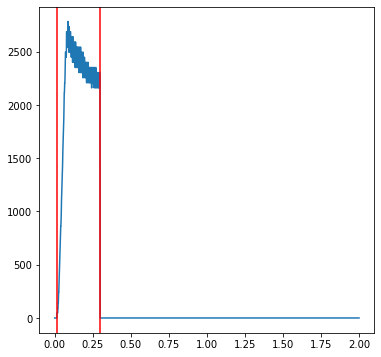

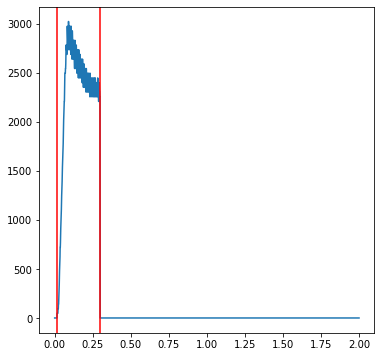

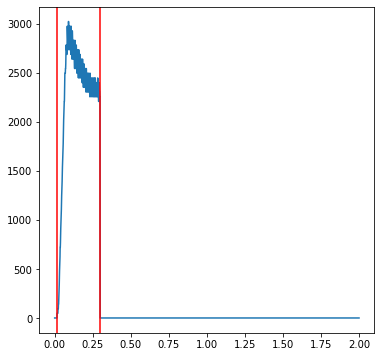

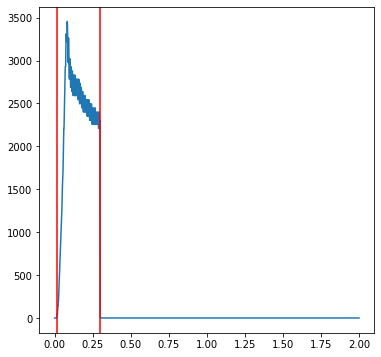

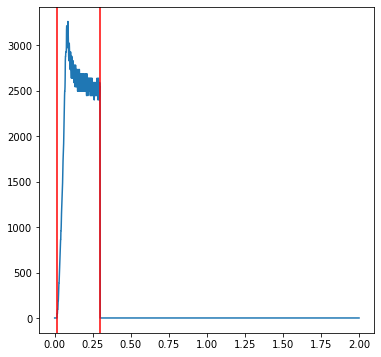

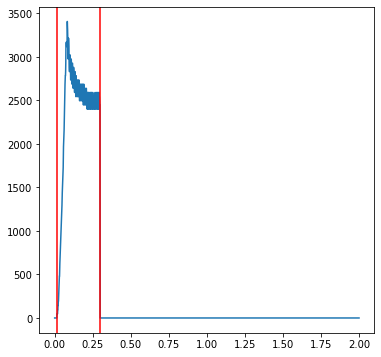

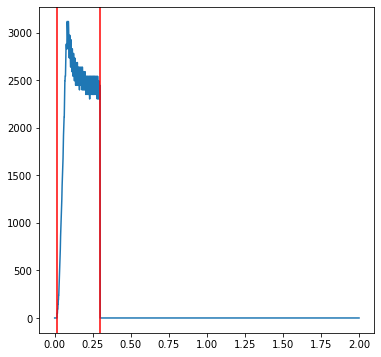

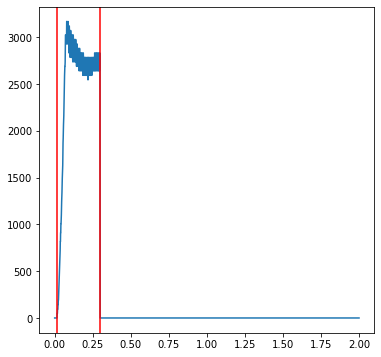

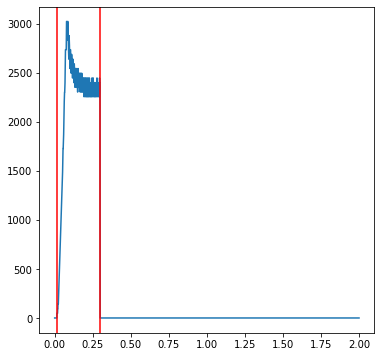

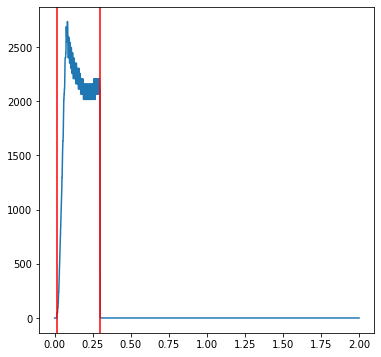

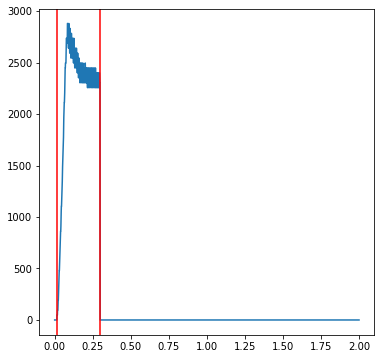

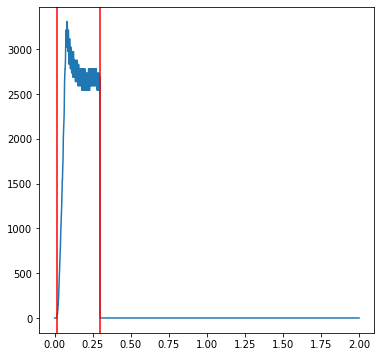

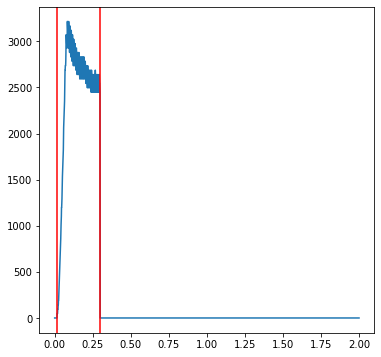

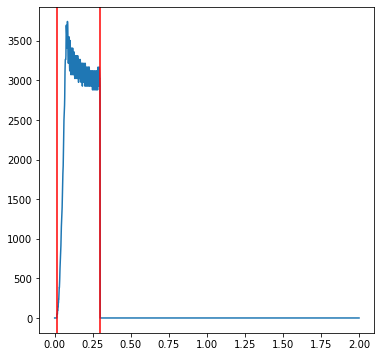

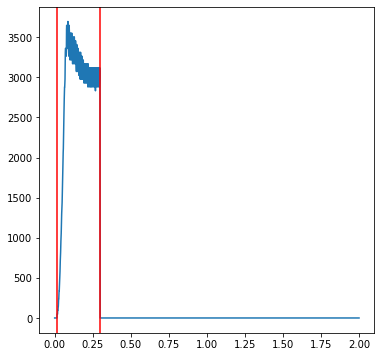

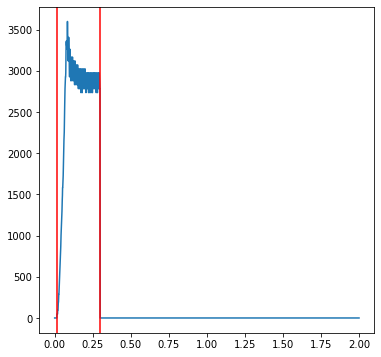

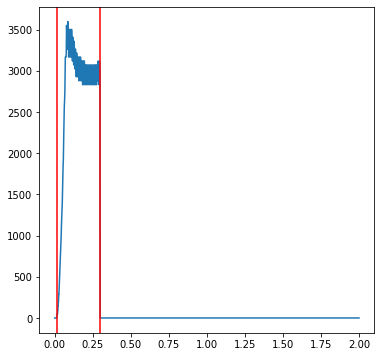

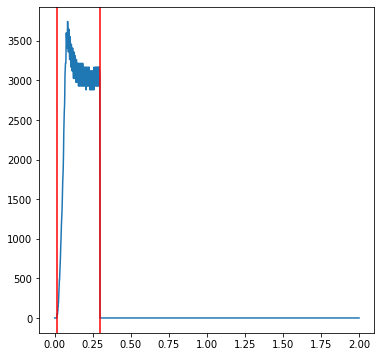

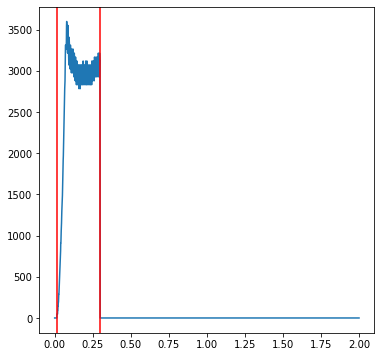

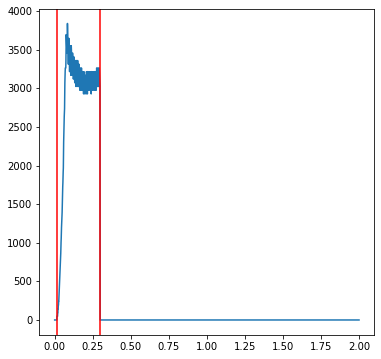

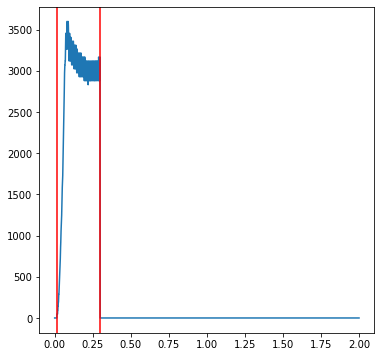

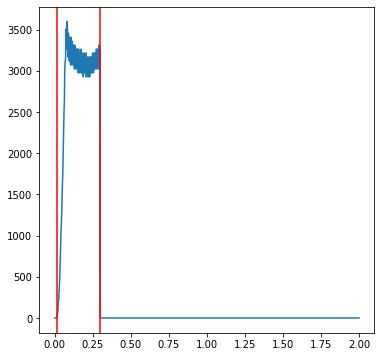

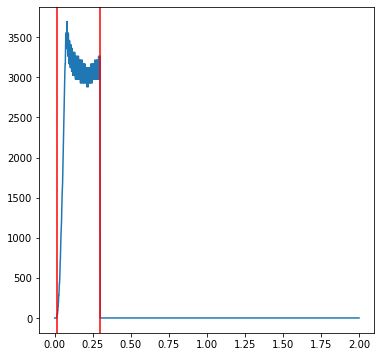

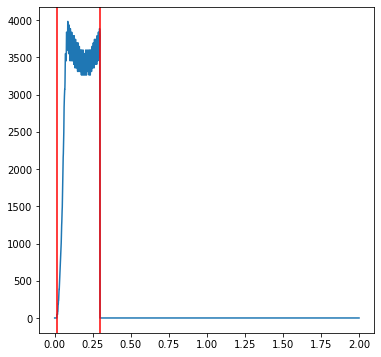

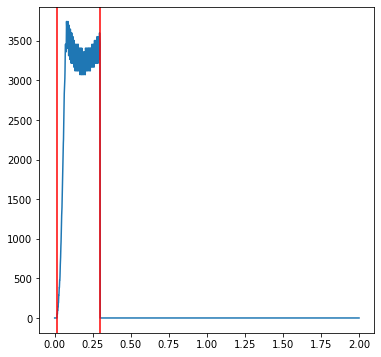

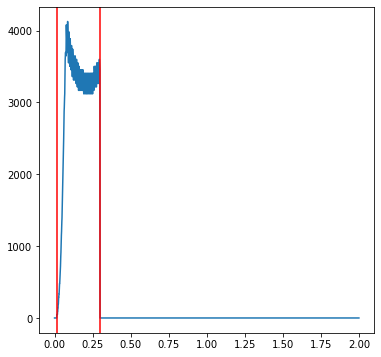

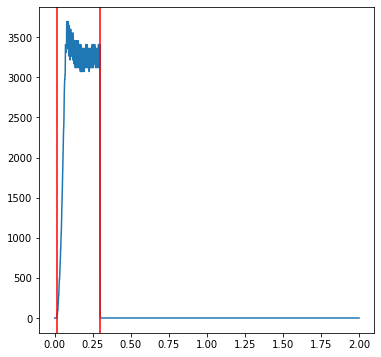

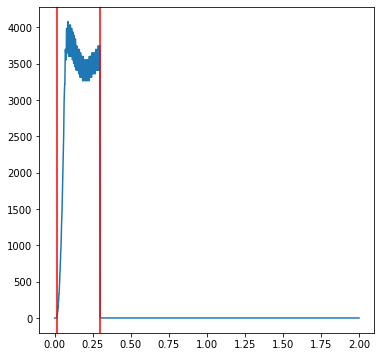

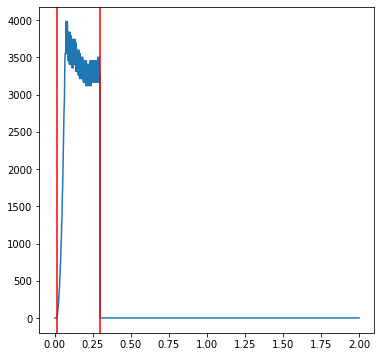

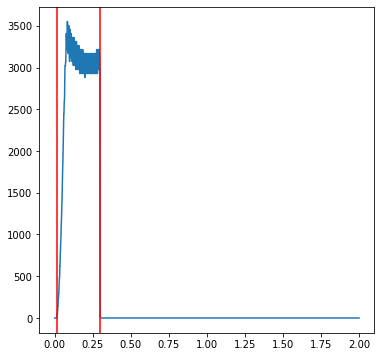

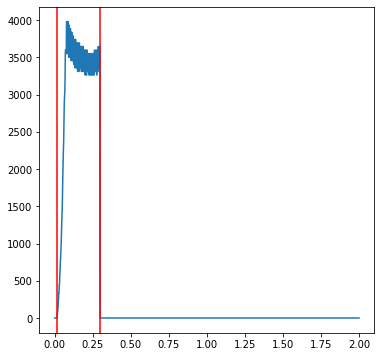

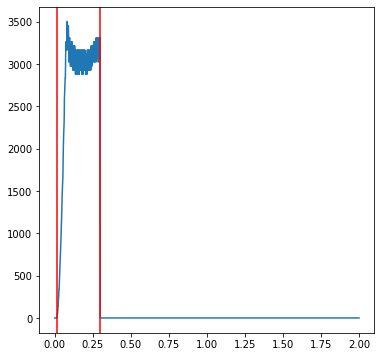

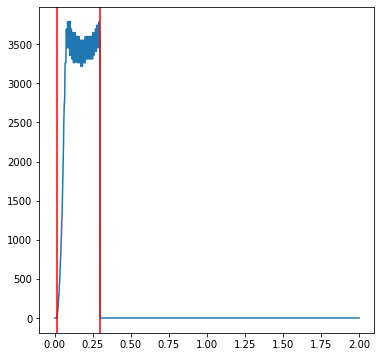

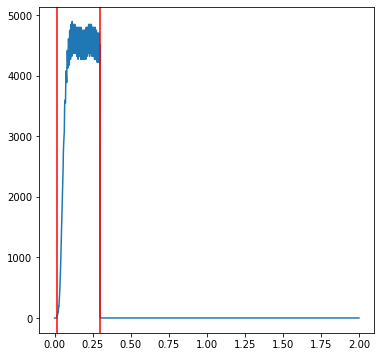

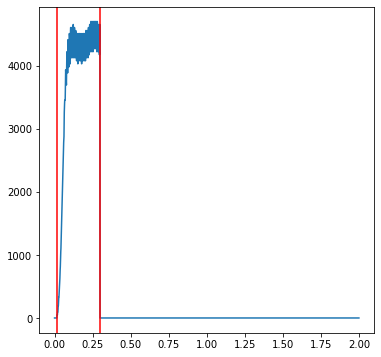

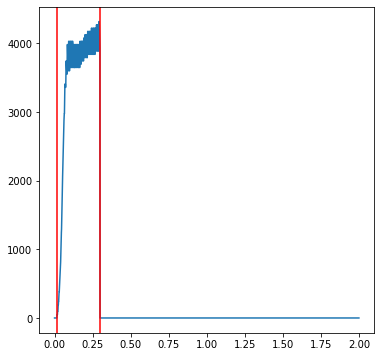

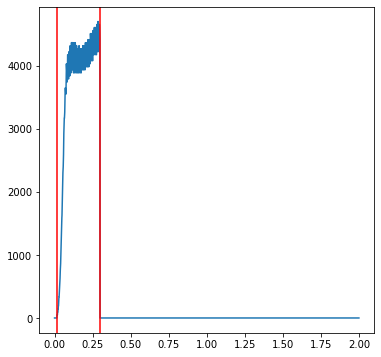

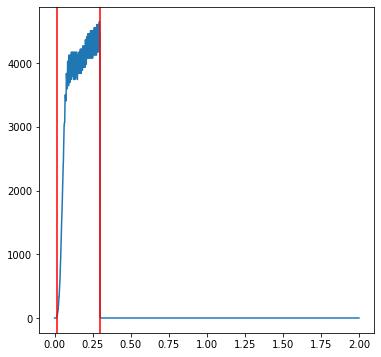

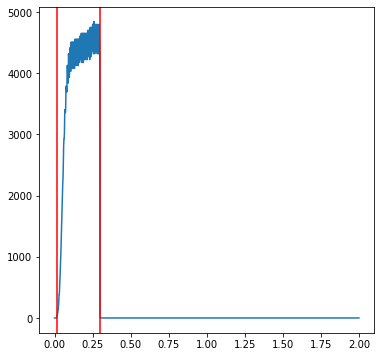

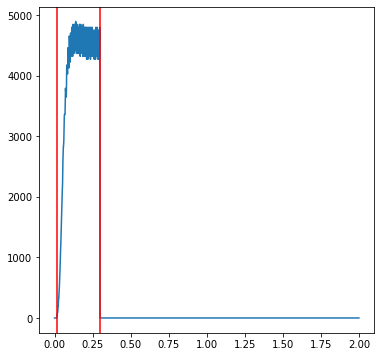

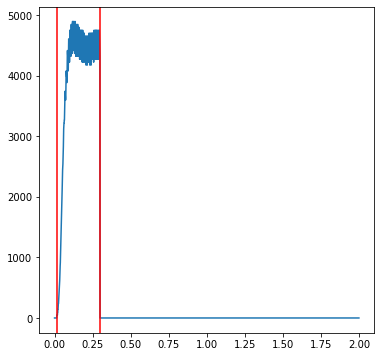

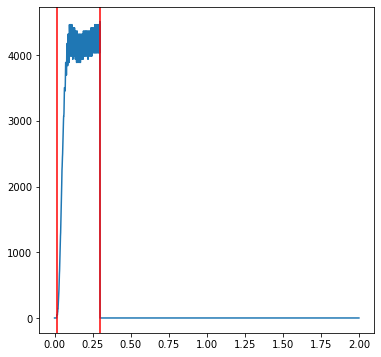

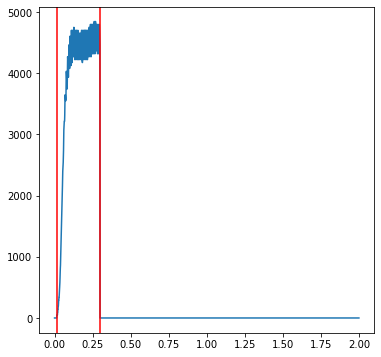

In [6]:
for i,sig in enumerate(data_buf['power']):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(sig[:,0],sig[:,1])
    for ind in seg_ind['power'][i]:
        plt.axvline(x=sig[ind,0],color='r')

In [11]:
### 2. feature generation
def power_density_spectrum(sig):
    n=len(sig)
    Y = np.fft.fft(sig) # n-point discrete Fourier transform via FFT
    Y = Y / np.sqrt(n) # regularize the spectrum to preserve energy
    Y = abs(Y*Y)
    Y[1:int((n-1)/2)+1] *= 2 # freq=0 & freq=(1+k) when n=2k+1 component should not be doubled after taking a single side
    return Y[:int(n/2)+1] # signal power density spectrum

features = {label:[] for label in feat_labels}

### a. using information in 'discriptions' to fill features

### b. using information in data['power'] to fill features

### c. using information in data['force'] to fill features

# # example:
def features_freq(signal, label):
    Y = power_density_spectrum(signal)
    maxY = np.max(Y)
    max_index = np.where(Y==maxY)[0][0]
    if label == 'freq_f2':        
        return maxY
    elif label == 'freq_f1':
        return max_index
    else : 
        Y = np.delete(Y, max_index)
        max2Y = np.max(Y)
        max2Y_index = np.where(Y==maxY)[0][0]
        if label == 'freq_f4':
            return max2Y
        return max2Y_index
    
tmp_f = data_buf['force']
for sig in tmp_f:
    for label in ['freq_f1', 'freq_f2']:
        features[label].append(features_freq(sig, label))
    for label in ['freq_f3', 'freq_f4']:
        features[label].append(features_freq(sig, label))


In [12]:
features

{'welding_pressure': [],
 'pre_height': [],
 'post_height': [],
 'height_change': [],
 'time_f1': [],
 'time_f2': [],
 'time_f3': [],
 'time_f4': [],
 'freq_f1': [80000,
  79990,
  79998,
  79970,
  79960,
  79966,
  79996,
  79991,
  79999,
  79975,
  79983,
  55140,
  79995,
  79994,
  79984,
  79986,
  79998,
  79999,
  79998,
  55437,
  55574,
  55407,
  55422,
  54387,
  55530,
  53879,
  54429,
  55439,
  55439,
  53485,
  53439,
  53425,
  53458,
  54076,
  53274,
  53255,
  53438,
  53393,
  53154,
  52925,
  53089,
  52928,
  52983,
  53119,
  53098,
  52934,
  52822,
  53001,
  52851,
  53045,
  53080,
  53025,
  52881,
  52988,
  53092,
  52350,
  52973,
  53161,
  52598,
  64501,
  64540,
  64389,
  64459,
  53028,
  64430,
  64549,
  64537,
  64413,
  64470],
 'freq_f2': [1.6676565424078602e-05,
  1.6545237093518163e-05,
  1.6709847158467754e-05,
  1.663922081748239e-05,
  1.665099110531809e-05,
  1.6663746946694082e-05,
  1.676854644638471e-05,
  1.681279067037081e-05,
  

In [9]:

def fisher_ratio(f1,f2):
    miu1 = np.mean(f1)
    miu2 = np.mean(f2)
    
    sigma1_square = pvariance(f1)
    print(sigma1_square)
    sigma2_square = pvariance(f2)
    print(sigma2_square)
    
#     l1=len(f1); l2=len(f2);
#     return np.power(miu1-miu2,2)*l1*l2/(l1*sigma1_square + l2*sigma2_square)/(l1+l2)
    return np.power(miu1-miu2,2)/(sigma1_square + sigma2_square)

print(fisher_ratio(np.array([2,2]),np.array([1,3])))

0
1
0.0


In [10]:
### 3. Fisher's ratio
welding_class = descriptions.loc[:,'Class Label'].values
classes = ['I','II','III']
class_index = {}
for c in classes:
    class_index[c] = np.where(welding_class == c)[0]

features_Fisher_ratio = {}
for label in feat_labels:
    features_Fisher_ratio[label] = []
    print(features[label])
    print(label)
    tmp = np.array(features[label])
    for c in classes[:2]:
        f_rat = fisher_ratio(tmp[class_index['III']],tmp[class_index[c]])
        features_Fisher_ratio[label].append(f_rat)



[]
welding_pressure


IndexError: index 19 is out of bounds for axis 0 with size 0

In [ ]:
### 4. Feature selection
feature_f_rat_sum = {label:np.sum(features_Fisher_ratio[label]) for label in feat_labels}
# visualize features

In [ ]:
### 5. Classification
feat_selected = ['welding_pressure', 'time_f1', 'freq_f1']
# plot histograms for each feature
for label in feat_selected:
    fig = plt.figure(figsize=(6, 6))
    feature_value = features[label]
    for c_ind in class_index:
        plt.hist(feature_value[c_ind], label = 'test data', bins=int(math.sqrt(len(feature_value[c_ind]))))
    plt.xlabel('bins')
    plt.ylabel('instances')
    plt.show()

# determine monitoring limits for each feature; using bayesian
# find misdetection rate
